#### Loading the libraries used for text-preprocessing

In [1]:
# !pip install spacy
# !python -m spacy download en_core_web_sm

In [1]:
import pandas as pd
# NLP-related imports
import re
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
import string
from spellchecker import SpellChecker
import contractions
import codecs
import unidecode
import re
import spacy

#set the stopwords list
stopwords = stopwords.words('english')
stopwords.remove('no')
stopwords.remove('not')
stopwords.append('would')

#### Merging all mined tweets in one file

In [2]:
# # Merge all the mined files to one final file
# files = ['Feb','Feb06_07','Mar16','Mar24','Mar28','Mar31','Apr30','May','June14','June30']

# # Transfers the January tweets to a new file containing the header
# Jan_ids = pd.read_csv(r'ids_final_Jan.csv', sep=",", parse_dates=False)
# Jan_ids.to_csv('final_ids.csv', mode='a', header=True, index=False)

# # Appends the rest of the tweets to the created file
# for file in files:
#     file_ids = pd.read_csv(r'ids_final_{}.csv'.format(file), sep=",", parse_dates=False)
#     print(file, len(file_ids))
#     file_ids.to_csv('final_ids.csv', mode='a', header=False, index=False)
#     del file_ids

#### Sampling the hand-labelled dataset

In [ ]:
final = pd.read_csv(r'final_ids.csv', sep=",", parse_dates=False)
print(len(final))
final.drop(columns=['place'], inplace=True)
print(final.columns)
dates = final['created_at'].unique()
# print(np.sort(dates, axis=0))
print(len(dates))
final['created_at'] =  pd.to_datetime(final['created_at'], infer_datetime_format=True)
print(final.dtypes)

In [ ]:
train_sample = final[(final['created_at'] >= '2020-01-22') & (final['created_at'] < '2020-06-15')]
print('Number of days:', len(train_sample['created_at'].unique()))
print('Number of tweets:', len(train_sample))

In [ ]:
train_dates = train_sample['created_at'].unique()

for date in train_dates:
    # Randomly sample 18 tweets to per day to train the ML classifier (2610 tweets in total)
    sampledf = train_sample[train_sample['created_at'] == date].sample(n=18, random_state=1)
    sampledf.to_csv(r'train_sample.csv', header=True, mode='a+', index=False)
    del sampledf

In [ ]:
train_final = pd.read_csv(r'train_sample.csv', sep=",", parse_dates=False)
# Removing the header rows that were added while sampling from the file
train_final = train_final[train_final.created_at != 'created_at'].reset_index().drop(columns=['index'])
train_final['created_at'] =  pd.to_datetime(train_final['created_at'], infer_datetime_format=True)
print(len(train_final))

train_final = train_final.drop(columns=['id_str','retweet_count'])

train_final.dtypes

In [ ]:
train_final.to_csv(r'train_final_unlabelled.csv', sep=',', header=True, index=False)

#### Class balance for the hand-labelled dataset

In [3]:
train_final = pd.read_csv(r'train_final.csv', sep=",", parse_dates=False)
#train_final['created_at'] =  pd.to_datetime(train_final['created_at'], infer_datetime_format=True)

train_final

,created_at,RT_text,Sentiment
0,23-01-20,Rep. Ruffy Biazon is calling for the suspensio...,Neu
1,23-01-20,A new #CoronavirusOutbreak has put a spotlight...,Neu
2,23-01-20,This kind of a pullback in Chinese stocks like...,Pos
3,23-01-20,What you need to know in #Brazil today:\n\n⚠️ ...,Neu
4,23-01-20,@Chance4Gardener I know! I told my doctor PCP ...,Pos
...,...,...,...
2605,03-06-20,It's #VolunteerWeek2020\n\nWe want to thank ou...,Pos
2606,03-06-20,We have joined with @NIHRresearch to boost sup...,Neu
2607,03-06-20,NEWS RELEASE: The ICAO Council adopted a new r...,Pos
2608,03-06-20,#cancelApexamspromotestudents\n#CancelTSExamsP...,Neg


In [4]:
train_final.Sentiment.value_counts()

Neu    1441
Neg     853
Pos     316
Name: Sentiment, dtype: int64

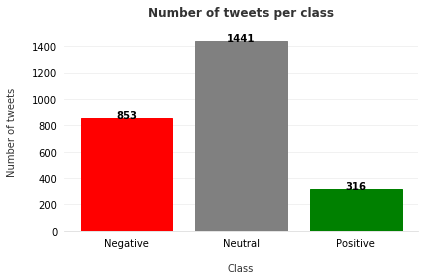

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sentiment = ['Negative','Neutral','Positive']
counts = [853, 1441, 316]
# sns.set(style="whitegrid")
# ax = sns.barplot(x=sentiment, y=counts)

fig, ax = plt.subplots()

# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=sentiment,
    height=counts)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Grab the color of the bars so we can make the
# text the same color.
bars[0].set_color('r')
bars[1].set_color('gray')
bars[2].set_color('g')
bar_color = 'black'

# Add text annotations to the top of the bars.
# Note, you'll have to adjust this slightly (the 0.3)
# with different data.
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.3,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )

# Add labels and a title.
ax.set_xlabel('Class', labelpad=15, color='#333333')
ax.set_ylabel('Number of tweets', labelpad=15, color='#333333')
ax.set_title('Number of tweets per class', pad=15, color='#333333',
             weight='bold')
fig.tight_layout()

#### Vader sentiment classification accuracy

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
train_final = pd.read_csv(r'train_final.csv', sep=",", parse_dates=False)
#train_final['created_at'] =  pd.to_datetime(train_final['created_at'], infer_datetime_format=True)

train_final

In [ ]:
vader_sent = []

analyser = SentimentIntensityAnalyzer()
    
def sentiment_Vader(tweet):
    tweet_sent = analyser.polarity_scores(tweet)
    if tweet_sent['compound'] >= 0.05 : 
        return "Pos"
    elif tweet_sent['compound'] <= - 0.05 : 
        return "Neg" 
    else : 
        return "Neu"

for i in range(len(train_final)):
    vader_sent.append(sentiment_Vader(train_final['RT_text'][i]))
    
train_final['Vader_sentiment'] = vader_sent
    
train_final

In [ ]:
# train_final.to_csv('train_Vader.csv', header=True, index=False)

In [7]:
df2 = pd.read_csv('train_Vader.csv')

df2

,created_at,RT_text,Sentiment,preprocessed_text,Vader_sentiment
0,23-01-20,Rep. Ruffy Biazon is calling for the suspensio...,Neu,rep ruffy biazon call suspension direct flight...,Pos
1,23-01-20,A new #CoronavirusOutbreak has put a spotlight...,Neu,new coronavirusoutbreak put spotlight china ’ ...,Neu
2,23-01-20,This kind of a pullback in Chinese stocks like...,Pos,kind pullback chinese stock like lk definitely...,Pos
3,23-01-20,What you need to know in #Brazil today:\n\n⚠️ ...,Neu,need know brazil today :warning: coronavirusou...,Pos
4,23-01-20,@Chance4Gardener I know! I told my doctor PCP ...,Pos,know tell doctor pcp heather look like gwyneth...,Neg
...,...,...,...,...,...
2605,03-06-20,It's #VolunteerWeek2020\n\nWe want to thank ou...,Pos,volunteerweek want thank volunteer coronavirus...,Pos
2606,03-06-20,We have joined with @NIHRresearch to boost sup...,Neu,join boost support research effect covid pande...,Pos
2607,03-06-20,NEWS RELEASE: The ICAO Council adopted a new r...,Pos,news release icao council adopt new report rec...,Neu
2608,03-06-20,#cancelApexamspromotestudents\n#CancelTSExamsP...,Neg,cancelapexamspromotestudents canceltsexamsprom...,Neg


In [8]:
Correct = 0
for i in range(len(df2)):
    if df2.Sentiment[i]==df2.Vader_sentiment[i]:
        Correct=Correct+1

print('Accuracy of Vader:', round(Correct/len(df2)*100,2), '%')

Accuracy of Vader: 43.6 %


#### Text pre-processing of hand-labelled dataset

In [4]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                       "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" } 

In [3]:
nlp = spacy.load(r'C:\Users\D.Petkidis\Anaconda3\Lib\site-packages\en_core_web_sm\en_core_web_sm-2.3.1')

#if the previous token is either not or no then apply the negation to the following token
def negation(tokens):    
    i=1
    for i in range(len(tokens)-1):
        if (tokens[i]=='not')or(tokens[i]=='no'):
            tokens[i+1]='neg_'+tokens[i+1]
            tokens[i] = ''
        i=i+1
    #removing empty tokens caused by replacing not or no
    tokens = [token for token in tokens if token]
    return tokens

def spacy_cleaner(text):
    text = emoji.demojize(text)
    try:
        decoded = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
    except:
        decoded = unidecode.unidecode(text)

    apostrophe_handled = re.sub("’", "'", decoded)
    expanded = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in apostrophe_handled.split(" ")])
    parsed = nlp(expanded)
    final_tokens = []
    for t in parsed:
        if t.is_punct or t.is_space or t.like_num or t.like_url or str(t).startswith('@'):
            pass
        else:
            if t.lemma_ == '-PRON-':
                final_tokens.append(str(t))
            else:
                sc_removed = re.sub("[^a-zA-Z]", '', str(t.lemma_))
                if len(sc_removed) > 1:
                    final_tokens.append(sc_removed)
    
    final_tokens = [token if emoticon_re.search(token) else re.sub(r'(.)\1+', r'\1\1', token) for token in final_tokens]
#    final_tokens = [term for term in final_tokens if term not in stopwords]
    final_tokens = negation(final_tokens)
    final_tokens = [term.lower() for term in final_tokens]
    
    joined = ' '.join(final_tokens)
    spell_corrected = re.sub(r'(.)\1+', r'\1\1', joined)
    
    return spell_corrected

In [221]:
df = pd.read_csv(r'train_final.csv', sep=",", parse_dates=False)

df

,created_at,RT_text,Sentiment,preprocessed_text
0,23-01-20,Rep. Ruffy Biazon is calling for the suspensio...,Neu,rep ruffy biazon call suspension direct flight...
1,23-01-20,A new #CoronavirusOutbreak has put a spotlight...,Neu,new coronavirusoutbreak put spotlight china ’ ...
2,23-01-20,This kind of a pullback in Chinese stocks like...,Pos,kind pullback chinese stock like lk definitely...
3,23-01-20,What you need to know in #Brazil today:\n\n⚠️ ...,Neu,need know brazil today :warning: coronavirusou...
4,23-01-20,@Chance4Gardener I know! I told my doctor PCP ...,Pos,know tell doctor pcp heather look like gwyneth...
...,...,...,...,...
2605,03-06-20,It's #VolunteerWeek2020\n\nWe want to thank ou...,Pos,volunteerweek want thank volunteer coronavirus...
2606,03-06-20,We have joined with @NIHRresearch to boost sup...,Neu,join boost support research effect covid pande...
2607,03-06-20,NEWS RELEASE: The ICAO Council adopted a new r...,Pos,news release icao council adopt new report rec...
2608,03-06-20,#cancelApexamspromotestudents\n#CancelTSExamsP...,Neg,cancelapexamspromotestudents canceltsexamsprom...


In [223]:
df['Spacy_text']=[spacy_cleaner(t) for t in df.RT_text]

df

,created_at,RT_text,Sentiment,preprocessed_text,Spacy_text
0,23-01-20,Rep. Ruffy Biazon is calling for the suspensio...,Neu,rep ruffy biazon call suspension direct flight...,rep ruffy biazon be call for the suspension of...
1,23-01-20,A new #CoronavirusOutbreak has put a spotlight...,Neu,new coronavirusoutbreak put spotlight china ’ ...,new coronavirusoutbreak have put spotlight on ...
2,23-01-20,This kind of a pullback in Chinese stocks like...,Pos,kind pullback chinese stock like lk definitely...,this kind of pullback in chinese stock like lk...
3,23-01-20,What you need to know in #Brazil today:\n\n⚠️ ...,Neu,need know brazil today :warning: coronavirusou...,what you need to know in brazil today warn cor...
4,23-01-20,@Chance4Gardener I know! I told my doctor PCP ...,Pos,know tell doctor pcp heather look like gwyneth...,i know i tell my doctor pcp heather who look l...
...,...,...,...,...,...
2605,03-06-20,It's #VolunteerWeek2020\n\nWe want to thank ou...,Pos,volunteerweek want thank volunteer coronavirus...,it be volunteerweek we want to thank our volun...
2606,03-06-20,We have joined with @NIHRresearch to boost sup...,Neu,join boost support research effect covid pande...,we have join with to boost support for researc...
2607,03-06-20,NEWS RELEASE: The ICAO Council adopted a new r...,Pos,news release icao council adopt new report rec...,news release the icao council adopt new report...
2608,03-06-20,#cancelApexamspromotestudents\n#CancelTSExamsP...,Neg,cancelapexamspromotestudents canceltsexamsprom...,cancelapexamspromotestudent canceltsexamspromo...


In [ ]:
# df.to_csv('spacy_train_final_data.csv', header=True, index=False)

#### Sentiment Analysis model training using the hand-labelled dataset

In [9]:
import pickle
import joblib
import numpy as np
from collections import Counter
# Train-test split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
# Oversampling
from imblearn.over_sampling import SMOTE
# Models
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# Features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
# Encoder
from sklearn.preprocessing import LabelEncoder
# Evaluation
from sklearn.metrics.classification import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

C:\Users\D.Petkidis\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\D.Petkidis\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\D.Petkidis\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and wil

In [10]:
def clf_CV(splits, X, Y, pipeline, average_method):
    
    #Using stratified k-fold CV for the evaluation    
    print('Stratified k-Fold CV')
    stratkfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for train, test in stratkfold.split(X, Y):
        clf_fit = pipeline.fit(X[train], Y[train])
        prediction = clf_fit.predict(X[test])
        scores = clf_fit.score(X[test],Y[test])
        
        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction, average=average_method)*100)
        recall.append(recall_score(Y[test], prediction, average=average_method)*100)
        f1.append(f1_score(Y[test], prediction, average=average_method)*100)
        
#         targetnames = ['Neg','Neu','Pos']
#         print(classification_report(Y[test],prediction,target_names=targetnames))
#         print()
#         print(confusion_matrix(Y[test], prediction))


    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))
    
    return clf_fit,prediction

In [11]:
df = pd.read_csv('spacy_train_final_data.csv')

# Training the classifiers using different set of combinations (comment in and out SMOTE and/or change vectorizers to test)
tfidf = TfidfVectorizer(use_idf=True, smooth_idf=False, max_features=50000, ngram_range=(1, 1), lowercase=False, stop_words=None)
vectorizer = HashingVectorizer(n_features=2**18)

print()
print('SVM results:')
SMOTE_LinearSVM_pipeline = make_pipeline(tfidf, SMOTE(random_state=777), LinearSVC(multi_class='ovr'))
smote_SVM_model, y_SVM_pred = clf_CV(5, df['Spacy_text'], df['Sentiment'], SMOTE_LinearSVM_pipeline, 'macro')

print()
print('Logistic Regression results:')
SMOTE_LR_pipeline = make_pipeline(tfidf, SMOTE(random_state=777), LogisticRegression())
smote_LR_model, y_LR_pred = clf_CV(5, df['Spacy_text'], df['Sentiment'], SMOTE_LR_pipeline, 'macro')


Logistic Regression results:
Stratified k-Fold CV


C:\Users\D.Petkidis\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\D.Petkidis\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\D.Petkidis\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\D.Petkidis\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  war

accuracy: 60.80% (+/- 1.60%)
precision: 54.79% (+/- 1.35%)
recall: 54.15% (+/- 1.21%)
f1 score: 54.39% (+/- 1.20%)


#### Testing the performance of the selected model using a 80-20 split

In [ ]:
train_csv = pd.read_csv('spacy_train_final_data.csv')

x_train, x_test, y_train, y_test = train_test_split(train_csv.Spacy_text, train_csv.Sentiment, test_size=0.2, random_state=777)

# Train the classifier
tfidf = TfidfVectorizer(use_idf=True, smooth_idf=False, max_features=50000, ngram_range=(1, 1), lowercase=False, stop_words=None)
vectorizer = HashingVectorizer(n_features=2**18)

SMOTE_LR_pipeline = make_pipeline(tfidf, SMOTE(random_state=777, k_neighbors=3), LogisticRegression())
SMOTE_SVM_pipeline = make_pipeline(tfidf, SMOTE(random_state=777, k_neighbors=3), LinearSVC(multi_class='ovr'))

clf_fit = SMOTE_LR_pipeline.fit(x_train, y_train)
prediction = clf_fit.predict(x_test)
scores = clf_fit.score(x_test,y_test)

targetnames = ['Neg','Neu','Pos']
print(classification_report(y_test,prediction,target_names=targetnames))
print()
print(confusion_matrix(y_test, prediction))

#### Text pre-processing and Sentiment Analysis of all the mined tweets

In [ ]:
sentiment_analysis = pd.read_csv(r'final_ids.csv', sep=",", parse_dates=False)

sentiment_analysis['Spacy_text']=[spacy_cleaner(t) for t in sentiment_analysis.RT_text]

sentiment_analysis

In [ ]:
# sentiment_analysis.to_csv(r'final_data_v2.csv')

In [ ]:
sentiment_analysis = pd.read_csv(r'final_data_v2.csv')

sentiment_analysis

In [ ]:
print(len(sentiment_analysis))
print(sentiment_analysis.isna().sum())

sentiment_analysis = sentiment_analysis[sentiment_analysis['Spacy_text'].notna()]
print(len(sentiment_analysis))

In [ ]:
pred = clf_fit.predict(sentiment_analysis['Spacy_text'])

sentiment_analysis['ML_sentiment'] = pred

sentiment_analysis

In [ ]:
# sentiment_analysis.to_csv('final_sentiment_analysis.csv', index=False, header=True)

#### Aggregating daily sentiment values as labelled from the ML algorithm

In [ ]:
final_df = pd.read_csv(r'final_sentiment_analysis.csv', sep=",", parse_dates=False)

final_df

In [ ]:
date_sent = pd.DataFrame(columns=['Date', 'Pos', 'Neg', 'Neu'])

for date in final_df.created_at.unique():
    pos_date = 0
    neg_date = 0
    neu_date = 0
    for i in range(len(final_df)):
        if final_df.created_at[i] == date:
            if final_df.ML_sentiment[i] == 'Pos':
                pos_date = pos_date + 1
            elif final_df.ML_sentiment[i] == 'Neg':
                neg_date = neg_date + 1
            else:
                neu_date = neu_date + 1
    date_sent = date_sent.append({'Date': date, 'Pos': pos_date, 'Neg': neg_date, 'Neu': neu_date}, ignore_index=True)

In [ ]:
date_sent

In [ ]:
# date_sent.to_csv('date_sent_ML.csv', header=True, index=False)

#### Financial Data Feature creation

In [12]:
ftse = pd.read_excel('FTSE_complete.xlsx')
ftse = ftse.round(2)
ftse['Date'] =  pd.to_datetime(ftse['Date'], infer_datetime_format=True)
print(ftse.dtypes)
ftse = ftse[(ftse['Date'] >= '2020-01-20')]
print('Number of days:', len(ftse['Date'].unique()))
ftse

Date         datetime64[ns]
Adj Close           float64
dtype: object
Number of days: 162


,Date,Adj Close
0,2020-01-20,7651.40
1,2020-01-21,7610.70
2,2020-01-22,7571.90
3,2020-01-23,7507.70
4,2020-01-24,7586.00
...,...,...
157,2020-06-25,6147.10
158,2020-06-26,6159.30
159,2020-06-27,6192.55
160,2020-06-28,6209.18


In [13]:
returns_normal = []
returns_pct = []
movement = []
avg_past_3days = []
avg_past_2days = []
pct_change_3days = []
pct_change_2days = []

#Close difference % for the first date
returns_pct.append(-0.61)
returns_normal.append(-0.00076)
#0 is down, 1 is up
movement.append(0)
#Aggregated value for the past 2 and 3 days
avg_past_2days = [7660.1, 7654.3]
avg_past_3days = [7664.93, 7657.2, 7639.77]
#Change % in close prices the past 2 and 3 days
pct_change_2days = [-0.08, -0.08]
pct_change_3days = [-0.23, -0.15, -0.61]

for i in range(len(ftse)):
    if i>=1:
        returns_normal.append((ftse['Adj Close'][i] - ftse['Adj Close'][i-1])/ftse['Adj Close'][i-1])
        returns_pct.append(((ftse['Adj Close'][i] - ftse['Adj Close'][i-1])/ftse['Adj Close'][i-1])*100) 
        if (ftse['Adj Close'][i] >= ftse['Adj Close'][i-1]):
            movement.append(1)
        else:
            movement.append(0)
    if i>=2:
        avg_past_2days.append((ftse['Adj Close'][i-1] + ftse['Adj Close'][i-2])/2)
        pct_change_2days.append(((ftse['Adj Close'][i-1] - ftse['Adj Close'][i-2])/ftse['Adj Close'][i-2])*100)
    if i>=3:
        avg_past_3days.append((ftse['Adj Close'][i-1] + ftse['Adj Close'][i-2] + ftse['Adj Close'][i-3])/3)
        pct_change_3days.append(((ftse['Adj Close'][i-1] - ftse['Adj Close'][i-3])/ftse['Adj Close'][i-3])*100)

            
ftse['Returns_pct'] = returns_pct
ftse['Returns_normal'] = returns_normal
# ftse['Returns_normal'] = ftse['Returns_normal'].round(decimals=2)
ftse['Returns_pct'] = ftse['Returns_pct'].round(decimals=2)
ftse['Avg_past_3days'] = avg_past_3days
ftse['Avg_past_3days'] = ftse['Avg_past_3days'].round(decimals=2)
ftse['Avg_past_2days'] = avg_past_2days
ftse['Avg_past_2days'] = ftse['Avg_past_2days'].round(decimals=2)
ftse['pct_change_2days'] = pct_change_2days
ftse['pct_change_3days'] = pct_change_3days
ftse['movement'] = movement

ftse

,Date,Adj Close,Returns_pct,Returns_normal,Avg_past_3days,Avg_past_2days,pct_change_2days,pct_change_3days,movement
0,2020-01-20,7651.40,-0.61,-0.000760,7664.93,7660.10,-0.080000,-0.230000,0
1,2020-01-21,7610.70,-0.53,-0.005319,7657.20,7654.30,-0.080000,-0.150000,0
2,2020-01-22,7571.90,-0.51,-0.005098,7639.77,7631.05,-0.531929,-0.610000,0
3,2020-01-23,7507.70,-0.85,-0.008479,7611.33,7591.30,-0.509809,-1.039026,0
4,2020-01-24,7586.00,1.04,0.010429,7563.43,7539.80,-0.847872,-1.353358,1
...,...,...,...,...,...,...,...,...,...
157,2020-06-25,6147.10,0.38,0.003821,6229.47,6221.90,-3.107546,-1.936073,1
158,2020-06-26,6159.30,0.20,0.001985,6196.97,6135.40,0.382122,-2.737298,1
159,2020-06-27,6192.55,0.54,0.005398,6143.37,6153.20,0.198468,0.581348,1
160,2020-06-28,6209.18,0.27,0.002685,6166.32,6175.92,0.539834,0.739373,1


In [14]:
ftse = ftse.set_index('Date')

ftse['Previous_Close'] = ftse['Adj Close'].shift(1, fill_value=7657.20)

ftse

,Adj Close,Returns_pct,Returns_normal,Avg_past_3days,Avg_past_2days,pct_change_2days,pct_change_3days,movement,Previous_Close
Date,,,,,,,,,
2020-01-20,7651.40,-0.61,-0.000760,7664.93,7660.10,-0.080000,-0.230000,0,7657.20
2020-01-21,7610.70,-0.53,-0.005319,7657.20,7654.30,-0.080000,-0.150000,0,7651.40
2020-01-22,7571.90,-0.51,-0.005098,7639.77,7631.05,-0.531929,-0.610000,0,7610.70
2020-01-23,7507.70,-0.85,-0.008479,7611.33,7591.30,-0.509809,-1.039026,0,7571.90
2020-01-24,7586.00,1.04,0.010429,7563.43,7539.80,-0.847872,-1.353358,1,7507.70
...,...,...,...,...,...,...,...,...,...
2020-06-25,6147.10,0.38,0.003821,6229.47,6221.90,-3.107546,-1.936073,1,6123.70
2020-06-26,6159.30,0.20,0.001985,6196.97,6135.40,0.382122,-2.737298,1,6147.10
2020-06-27,6192.55,0.54,0.005398,6143.37,6153.20,0.198468,0.581348,1,6159.30


In [15]:
# import matplotlib.pyplot as plt
# import seaborn as sns

In [16]:
# ax = ftse['Returns_pct'].plot(linewidth=0.5);
# ax.set_ylabel('Close Difference %');

In [17]:
# ax = ftse['Adj Close'].plot(linewidth=0.5);
# ax.set_ylabel('Close');

#### ADF test for financial data

In [18]:
import statsmodels
from statsmodels.tsa.stattools import adfuller

In [19]:
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
        
    def ADF_Stationarity_Test(self, timeseries, printResults = True):
            #Dickey-Fuller test:
            adfTest = adfuller(timeseries, autolag='AIC')

            self.pValue = adfTest[1]

            if (self.pValue<self.SignificanceLevel):
                self.isStationary = True
            else:
                self.isStationary = False

            if printResults:
                dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
                #Add Critical Values
                for key,value in adfTest[4].items():
                    dfResults['Critical Value (%s)'%key] = value
                print('Augmented Dickey-Fuller Test Results:')
                print(dfResults)

In [20]:
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(ftse['Returns_pct'], printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

sTest.ADF_Stationarity_Test(ftse['Returns_normal'], printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.217686e+01
P-Value                 1.379916e-22
# Lags Used             0.000000e+00
# Observations Used     1.610000e+02
Critical Value (1%)    -3.471633e+00
Critical Value (5%)    -2.879665e+00
Critical Value (10%)   -2.576434e+00
dtype: float64
Is the time series stationary? True
Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.217621e+01
P-Value                 1.384380e-22
# Lags Used             0.000000e+00
# Observations Used     1.610000e+02
Critical Value (1%)    -3.471633e+00
Critical Value (5%)    -2.879665e+00
Critical Value (10%)   -2.576434e+00
dtype: float64
Is the time series stationary? True


#### Engineering ML sentiment features (polarity, lagged polarity, etc.) and constructing sentiment time-series

In [21]:
ML_sent = pd.read_csv('date_sent_ML.csv')

ML_sent['Date'] =  pd.to_datetime(ML_sent['Date'], infer_datetime_format=True)
print(ML_sent.dtypes)
ML_sent = ML_sent[(ML_sent['Date'] >= '2020-01-20') & (ML_sent['Date'] <= '2020-06-29')]
print('Number of days:', len(ML_sent['Date'].unique()))
ML_sent = ML_sent.sort_values(by='Date')
ML_sent = ML_sent.set_index('Date')

ML_sent

Date    datetime64[ns]
Pos              int64
Neg              int64
Neu              int64
dtype: object
Number of days: 160


,Pos,Neg,Neu
Date,,,
2020-01-22,184,1372,2468
2020-01-23,445,3104,6614
2020-01-24,496,3215,6228
2020-01-25,442,2794,4960
2020-01-26,452,2785,4698
...,...,...,...
2020-06-25,1743,5018,7080
2020-06-26,1599,5230,6927
2020-06-27,1538,5146,6721


In [22]:
polarity = []
polarity2 = []
negdailyprob = []
posdailyprob = []
negdiffprob = [None]
posdiffprob = [None]

for i in range(len(ML_sent)):
    negdailyprob.append( ML_sent['Neg'][i]/(ML_sent['Pos'][i]+ML_sent['Neg'][i]) )
    posdailyprob.append( ML_sent['Pos'][i]/(ML_sent['Pos'][i]+ML_sent['Neg'][i]) )
    polarity.append( (ML_sent['Neg'][i]-ML_sent['Pos'][i])/(ML_sent['Pos'][i]+ML_sent['Neg'][i]) )
    polarity2.append( (ML_sent['Pos'][i]-ML_sent['Neg'][i])/(ML_sent['Pos'][i]+ML_sent['Neg'][i]) )
    if i>=1:
        negdiffprob.append( (ML_sent['Neg'][i]/(ML_sent['Pos'][i]+ML_sent['Neg'][i])) - \
                           (ML_sent['Neg'][i-1]/(ML_sent['Pos'][i-1]+ML_sent['Neg'][i-1])) )
        
        posdiffprob.append( (ML_sent['Pos'][i]/(ML_sent['Pos'][i]+ML_sent['Neg'][i])) - \
                           (ML_sent['Pos'][i-1]/(ML_sent['Pos'][i-1]+ML_sent['Neg'][i-1])) )
            
            
            
ML_sent['neg_daily_prob'] = negdailyprob
ML_sent['pos_daily_prob'] = posdailyprob
ML_sent['neg_diff_prob'] = negdiffprob
ML_sent['pos_diff_prob'] = posdiffprob
ML_sent['polarity'] = polarity
ML_sent['polarity2'] = polarity2

ML_sent

,Pos,Neg,Neu,neg_daily_prob,pos_daily_prob,neg_diff_prob,pos_diff_prob,polarity,polarity2
Date,,,,,,,,,
2020-01-22,184,1372,2468,0.881748,0.118252,NaN,NaN,0.763496,-0.763496
2020-01-23,445,3104,6614,0.874613,0.125387,-0.007136,0.007136,0.749225,-0.749225
2020-01-24,496,3215,6228,0.866343,0.133657,-0.008269,0.008269,0.732687,-0.732687
2020-01-25,442,2794,4960,0.863412,0.136588,-0.002932,0.002932,0.726823,-0.726823
2020-01-26,452,2785,4698,0.860365,0.139635,-0.003047,0.003047,0.720729,-0.720729
...,...,...,...,...,...,...,...,...,...
2020-06-25,1743,5018,7080,0.742198,0.257802,0.001890,-0.001890,0.484396,-0.484396
2020-06-26,1599,5230,6927,0.765852,0.234148,0.023654,-0.023654,0.531703,-0.531703
2020-06-27,1538,5146,6721,0.769898,0.230102,0.004047,-0.004047,0.539797,-0.539797


In [23]:
ML_sent['polarity_lag1'] = ML_sent['polarity'].shift(1)
ML_sent['polarity_lag2'] = ML_sent['polarity'].shift(2)
ML_sent['polarity_lag3'] = ML_sent['polarity'].shift(3)

ML_sent['polarity2_lag1'] = ML_sent['polarity2'].shift(1)
ML_sent['polarity2_lag2'] = ML_sent['polarity2'].shift(2)
ML_sent['polarity2_lag3'] = ML_sent['polarity2'].shift(3)

ML_sent['polarity2_diff'] = (ML_sent['polarity2']-ML_sent['polarity2'].shift(1))

ML_sent['polarity2diff_lag1'] = ML_sent['polarity2_diff'].shift(1)
ML_sent['polarity2diff_lag2'] = ML_sent['polarity2_diff'].shift(2)

ML_sent

,Pos,Neg,Neu,neg_daily_prob,pos_daily_prob,neg_diff_prob,pos_diff_prob,polarity,polarity2,polarity_lag1,polarity_lag2,polarity_lag3,polarity2_lag1,polarity2_lag2,polarity2_lag3,polarity2_diff,polarity2diff_lag1,polarity2diff_lag2
Date,,,,,,,,,,,,,,,,,,
2020-01-22,184,1372,2468,0.881748,0.118252,NaN,NaN,0.763496,-0.763496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-23,445,3104,6614,0.874613,0.125387,-0.007136,0.007136,0.749225,-0.749225,0.763496,NaN,NaN,-0.763496,NaN,NaN,0.014271,NaN,NaN
2020-01-24,496,3215,6228,0.866343,0.133657,-0.008269,0.008269,0.732687,-0.732687,0.749225,0.763496,NaN,-0.749225,-0.763496,NaN,0.016539,0.014271,NaN
2020-01-25,442,2794,4960,0.863412,0.136588,-0.002932,0.002932,0.726823,-0.726823,0.732687,0.749225,0.763496,-0.732687,-0.749225,-0.763496,0.005863,0.016539,0.014271
2020-01-26,452,2785,4698,0.860365,0.139635,-0.003047,0.003047,0.720729,-0.720729,0.726823,0.732687,0.749225,-0.726823,-0.732687,-0.749225,0.006094,0.005863,0.016539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-25,1743,5018,7080,0.742198,0.257802,0.001890,-0.001890,0.484396,-0.484396,0.480617,0.483903,0.475593,-0.480617,-0.483903,-0.475593,-0.003779,0.003287,-0.008310
2020-06-26,1599,5230,6927,0.765852,0.234148,0.023654,-0.023654,0.531703,-0.531703,0.484396,0.480617,0.483903,-0.484396,-0.480617,-0.483903,-0.047307,-0.003779,0.003287
2020-06-27,1538,5146,6721,0.769898,0.230102,0.004047,-0.004047,0.539797,-0.539797,0.531703,0.484396,0.480617,-0.531703,-0.484396,-0.480617,-0.008093,-0.047307,-0.003779


In [24]:
# ax = ML_sent['polarity'].plot(marker='.', alpha=0.5, figsize=(11, 3.5))

# cols_plot = ['Returns_pct', 'Returns_normal']
# axes = ftse[cols_plot].plot(marker='.', alpha=0.5, figsize=(11, 9), subplots=True)

#### ADF test for polarity time-series

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -2.623551
P-Value                   0.088227
# Lags Used               0.000000
# Observations Used     158.000000
Critical Value (1%)      -3.472431
Critical Value (5%)      -2.880013
Critical Value (10%)     -2.576619
dtype: float64
Is the time series stationary? False


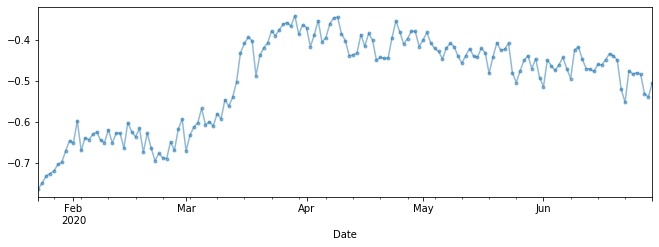

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

sTest = StationarityTests()
sTest.ADF_Stationarity_Test(ML_sent['polarity2_lag1'][1:], printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

ax = ML_sent['polarity2_lag1'][1:].plot(marker='.', alpha=0.5, figsize=(11, 3.5))

#### Merging financial and sentiment dataframes in one dataset (23/01/2020 - 29/06/2020)

In [27]:
ftse_final = ftse.loc['2020-01-23':'2020-06-29']
ftse_final

,Adj Close,Returns_pct,Returns_normal,Avg_past_3days,Avg_past_2days,pct_change_2days,pct_change_3days,movement,Previous_Close
Date,,,,,,,,,
2020-01-23,7507.70,-0.85,-0.008479,7611.33,7591.30,-0.509809,-1.039026,0,7571.90
2020-01-24,7586.00,1.04,0.010429,7563.43,7539.80,-0.847872,-1.353358,1,7507.70
2020-01-25,7499.05,-1.15,-0.011462,7555.20,7546.85,1.042929,0.186215,0,7586.00
2020-01-26,7455.58,-0.58,-0.005797,7530.92,7542.52,-1.146190,-0.115215,0,7499.05
2020-01-27,7412.10,-0.58,-0.005832,7513.54,7477.32,-0.579673,-1.719220,0,7455.58
...,...,...,...,...,...,...,...,...,...
2020-06-25,6147.10,0.38,0.003821,6229.47,6221.90,-3.107546,-1.936073,1,6123.70
2020-06-26,6159.30,0.20,0.001985,6196.97,6135.40,0.382122,-2.737298,1,6147.10
2020-06-27,6192.55,0.54,0.005398,6143.37,6153.20,0.198468,0.581348,1,6159.30


In [28]:
ML_sent_final = ML_sent.loc['2020-01-23':'2020-06-29']
ML_sent_final

,Pos,Neg,Neu,neg_daily_prob,pos_daily_prob,neg_diff_prob,pos_diff_prob,polarity,polarity2,polarity_lag1,polarity_lag2,polarity_lag3,polarity2_lag1,polarity2_lag2,polarity2_lag3,polarity2_diff,polarity2diff_lag1,polarity2diff_lag2
Date,,,,,,,,,,,,,,,,,,
2020-01-23,445,3104,6614,0.874613,0.125387,-0.007136,0.007136,0.749225,-0.749225,0.763496,NaN,NaN,-0.763496,NaN,NaN,0.014271,NaN,NaN
2020-01-24,496,3215,6228,0.866343,0.133657,-0.008269,0.008269,0.732687,-0.732687,0.749225,0.763496,NaN,-0.749225,-0.763496,NaN,0.016539,0.014271,NaN
2020-01-25,442,2794,4960,0.863412,0.136588,-0.002932,0.002932,0.726823,-0.726823,0.732687,0.749225,0.763496,-0.732687,-0.749225,-0.763496,0.005863,0.016539,0.014271
2020-01-26,452,2785,4698,0.860365,0.139635,-0.003047,0.003047,0.720729,-0.720729,0.726823,0.732687,0.749225,-0.726823,-0.732687,-0.749225,0.006094,0.005863,0.016539
2020-01-27,567,3271,5727,0.852267,0.147733,-0.008098,0.008098,0.704534,-0.704534,0.720729,0.726823,0.732687,-0.720729,-0.726823,-0.732687,0.016195,0.006094,0.005863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-25,1743,5018,7080,0.742198,0.257802,0.001890,-0.001890,0.484396,-0.484396,0.480617,0.483903,0.475593,-0.480617,-0.483903,-0.475593,-0.003779,0.003287,-0.008310
2020-06-26,1599,5230,6927,0.765852,0.234148,0.023654,-0.023654,0.531703,-0.531703,0.484396,0.480617,0.483903,-0.484396,-0.480617,-0.483903,-0.047307,-0.003779,0.003287
2020-06-27,1538,5146,6721,0.769898,0.230102,0.004047,-0.004047,0.539797,-0.539797,0.531703,0.484396,0.480617,-0.531703,-0.484396,-0.480617,-0.008093,-0.047307,-0.003779


In [29]:
Final_features = ML_sent_final.join(ftse_final, on=None, how='left', sort=False)

Final_features

,Pos,Neg,Neu,neg_daily_prob,pos_daily_prob,neg_diff_prob,pos_diff_prob,polarity,polarity2,polarity_lag1,...,polarity2diff_lag2,Adj Close,Returns_pct,Returns_normal,Avg_past_3days,Avg_past_2days,pct_change_2days,pct_change_3days,movement,Previous_Close
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-23,445,3104,6614,0.874613,0.125387,-0.007136,0.007136,0.749225,-0.749225,0.763496,...,NaN,7507.70,-0.85,-0.008479,7611.33,7591.30,-0.509809,-1.039026,0,7571.90
2020-01-24,496,3215,6228,0.866343,0.133657,-0.008269,0.008269,0.732687,-0.732687,0.749225,...,NaN,7586.00,1.04,0.010429,7563.43,7539.80,-0.847872,-1.353358,1,7507.70
2020-01-25,442,2794,4960,0.863412,0.136588,-0.002932,0.002932,0.726823,-0.726823,0.732687,...,0.014271,7499.05,-1.15,-0.011462,7555.20,7546.85,1.042929,0.186215,0,7586.00
2020-01-26,452,2785,4698,0.860365,0.139635,-0.003047,0.003047,0.720729,-0.720729,0.726823,...,0.016539,7455.58,-0.58,-0.005797,7530.92,7542.52,-1.146190,-0.115215,0,7499.05
2020-01-27,567,3271,5727,0.852267,0.147733,-0.008098,0.008098,0.704534,-0.704534,0.720729,...,0.005863,7412.10,-0.58,-0.005832,7513.54,7477.32,-0.579673,-1.719220,0,7455.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-25,1743,5018,7080,0.742198,0.257802,0.001890,-0.001890,0.484396,-0.484396,0.480617,...,-0.008310,6147.10,0.38,0.003821,6229.47,6221.90,-3.107546,-1.936073,1,6123.70
2020-06-26,1599,5230,6927,0.765852,0.234148,0.023654,-0.023654,0.531703,-0.531703,0.484396,...,0.003287,6159.30,0.20,0.001985,6196.97,6135.40,0.382122,-2.737298,1,6147.10
2020-06-27,1538,5146,6721,0.769898,0.230102,0.004047,-0.004047,0.539797,-0.539797,0.531703,...,-0.003779,6192.55,0.54,0.005398,6143.37,6153.20,0.198468,0.581348,1,6159.30


In [102]:
Final_features.isna().sum()

Pos                   0
Neg                   0
Neu                   0
neg_daily_prob        0
pos_daily_prob        0
neg_diff_prob         0
pos_diff_prob         0
polarity              0
polarity2             0
polarity_lag1         0
polarity_lag2         1
polarity_lag3         2
polarity2_lag1        0
polarity2_lag2        1
polarity2_lag3        2
polarity2_diff        0
polarity2diff_lag1    1
polarity2diff_lag2    2
Adj Close             0
Returns_pct           0
Returns_normal        0
Avg_past_3days        0
Avg_past_2days        0
pct_change_2days      0
pct_change_3days      0
movement              0
Previous_Close        0
dtype: int64

In [61]:
# Final_features.to_csv('Final_features.csv', header=True)

#### Dataset summary statistics

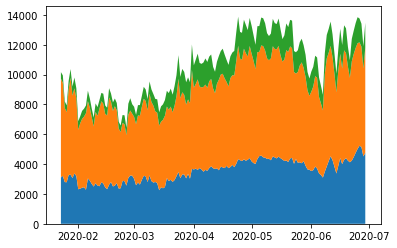

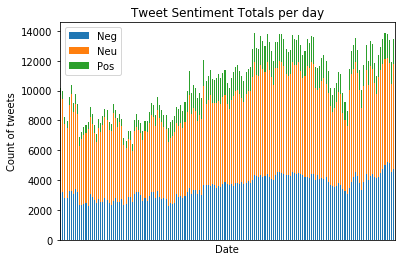

In [53]:
EDA = pd.read_csv('Final_features.csv')
EDA = EDA[['Date','Neg','Neu','Pos']]
# EDA = EDA.set_index('Date', drop=True)
EDA.Date = pd.to_datetime(EDA.Date)

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as plticker

dates = EDA.Date

plt.stackplot(dates, Final_features['Neg'], Final_features['Neu'], Final_features['Pos'])
xfmt = mdates.DateFormatter('%d-%m-%y')
ax.xaxis.set_major_formatter(xfmt)

plt.show()

plt.close()
EDA[["Neg", "Neu", "Pos"]].plot(kind="bar", stacked=True)
plt.title("Tweet Sentiment Totals per day")
plt.xlabel("Date")
plt.ylabel("Count of tweets")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.show()

In [54]:
total_neg = EDA.Neg.sum()
total_neu = EDA.Neu.sum()
total_pos = EDA.Pos.sum()
total = total_neg+total_neu+total_pos
print('Total Negative:',total_neg)
print('Total Neutral:', total_neu)
print('Total Positive:', total_pos)
print()
print('Total', total)
print('Average tweets per day', total/len(EDA))
print()
print('Total Negative %:',(total_neg/total)*100)
print('Total Neutral %:', (total_neu/total)*100)
print('Total Positive %:', (total_pos/total)*100)

monthly = EDA.groupby(EDA.Date.dt.to_period("M"))
monthly.sum()

Total Negative: 562568
Total Neutral: 918233
Total Positive: 198315

Total 1679116
Average tweets per day 10560.477987421384

Total Negative %: 33.503819867120555
Total Neutral %: 54.685501180383014
Total Positive %: 11.810678952496433


,Neg,Neu,Pos
Date,,,
2020-01,28099,51163,4984
2020-02,76725,134771,16593
2020-03,91106,154250,33378
2020-04,115798,183702,49698
2020-05,131464,209575,51098
2020-06,119376,184772,42564


#### Granger Causality Analysis (daily return percentage - polarity)

In [30]:
from statsmodels.tsa.stattools import grangercausalitytests

# Show granger causality with polarity (inverse values to examine the opposite effect)
grangerdata = Final_features[[ 'Returns_pct', 'polarity2_lag1']]

grangerdata

,Returns_pct,polarity2_lag1
Date,,
2020-01-23,-0.85,-0.763496
2020-01-24,1.04,-0.749225
2020-01-25,-1.15,-0.732687
2020-01-26,-0.58,-0.726823
2020-01-27,-0.58,-0.720729
...,...,...
2020-06-25,0.38,-0.480617
2020-06-26,0.20,-0.484396
2020-06-27,0.54,-0.531703


In [32]:
grangercausalitytests(grangerdata, maxlag=6, addconst=True, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7960  , p=0.0532  , df_denom=155, df_num=1
ssr based chi2 test:   chi2=3.8695  , p=0.0492  , df=1
likelihood ratio test: chi2=3.8228  , p=0.0506  , df=1
parameter F test:         F=3.7960  , p=0.0532  , df_denom=155, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0804  , p=0.0488  , df_denom=152, df_num=2
ssr based chi2 test:   chi2=6.3635  , p=0.0415  , df=2
likelihood ratio test: chi2=6.2379  , p=0.0442  , df=2
parameter F test:         F=3.0804  , p=0.0488  , df_denom=152, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2099  , p=0.0893  , df_denom=149, df_num=3
ssr based chi2 test:   chi2=6.9413  , p=0.0738  , df=3
likelihood ratio test: chi2=6.7913  , p=0.0789  , df=3
parameter F test:         F=2.2099  , p=0.0893  , df_denom=149, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6094  , p=0.1750  

{1: ({'ssr_ftest': (3.7959822748774825, 0.053181970670254645, 155.0, 1),
   'ssr_chi2test': (3.869452899552531, 0.04917254787242344, 1),
   'lrtest': (3.8228307039547644, 0.05055875459960377, 1),
   'params_ftest': (3.7959822748774315, 0.05318197067025649, 155.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (3.080411852640493, 0.04881967749521114, 152.0, 2),
   'ssr_chi2test': (6.3634823797968085, 0.0415133096004803, 2),
   'lrtest': (6.237902970338496, 0.04420349214697851, 2),
   'params_ftest': (3.0804118526404842, 0.048819677495212245, 152.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.2099332290540072, 0.08934109949502227, 149.0, 3),
   'ssr_chi2test': (6.941266786558895, 0.07379354817671692, 3),
   'lrtest': (6.791273137150029, 0.0788567095264464, 3),
   'params_ftest': (2.2099332290540277, 0.08934109949502071, 149.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0

In [33]:
granger_test_result = grangercausalitytests(grangerdata, maxlag=7, verbose=False)

optimal_lag = -1
F_test = -1.0
for key in granger_test_result.keys():
    _F_test_ = granger_test_result[key][0]['params_ftest'][0]
    if _F_test_ > F_test:
        F_test = _F_test_
        optimal_lag = key
        
print(F_test)
print(optimal_lag)

3.7959822748774315
1


#### Training the ML models for stock exchange movement prediction

In [109]:
Final_features= pd.read_csv('Final_features.csv')
Final_features['Date'] =  pd.to_datetime(Final_features['Date'], infer_datetime_format=True)
Final_features = Final_features.set_index('Date')
# For Polarity lag of 2 and 3 days
Final_features = Final_features.loc['2020-01-25':'2020-06-29']

Final_features

,Pos,Neg,Neu,neg_daily_prob,pos_daily_prob,neg_diff_prob,pos_diff_prob,polarity,polarity2,polarity_lag1,...,polarity2diff_lag2,Adj Close,Returns_pct,Returns_normal,Avg_past_3days,Avg_past_2days,pct_change_2days,pct_change_3days,movement,Previous_Close
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-25,442,2794,4960,0.863412,0.136588,-0.002932,0.002932,0.726823,-0.726823,0.732687,...,0.014271,7499.05,-1.15,-0.011462,7555.20,7546.85,1.042929,0.186215,0,7586.00
2020-01-26,452,2785,4698,0.860365,0.139635,-0.003047,0.003047,0.720729,-0.720729,0.726823,...,0.016539,7455.58,-0.58,-0.005797,7530.92,7542.52,-1.146190,-0.115215,0,7499.05
2020-01-27,567,3271,5727,0.852267,0.147733,-0.008098,0.008098,0.704534,-0.704534,0.720729,...,0.005863,7412.10,-0.58,-0.005832,7513.54,7477.32,-0.579673,-1.719220,0,7455.58
2020-01-28,582,3291,6494,0.849729,0.150271,-0.002538,0.002538,0.699458,-0.699458,0.704534,...,0.006094,7480.70,0.93,0.009255,7455.58,7433.84,-0.583187,-1.159480,1,7412.10
2020-01-29,602,3065,5528,0.835833,0.164167,-0.013896,0.013896,0.671666,-0.671666,0.699458,...,0.016195,7483.60,0.04,0.000388,7449.46,7446.40,0.925514,0.336929,1,7480.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-25,1743,5018,7080,0.742198,0.257802,0.001890,-0.001890,0.484396,-0.484396,0.480617,...,-0.008310,6147.10,0.38,0.003821,6229.47,6221.90,-3.107546,-1.936073,1,6123.70
2020-06-26,1599,5230,6927,0.765852,0.234148,0.023654,-0.023654,0.531703,-0.531703,0.484396,...,0.003287,6159.30,0.20,0.001985,6196.97,6135.40,0.382122,-2.737298,1,6147.10
2020-06-27,1538,5146,6721,0.769898,0.230102,0.004047,-0.004047,0.539797,-0.539797,0.531703,...,-0.003779,6192.55,0.54,0.005398,6143.37,6153.20,0.198468,0.581348,1,6159.30


In [110]:
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots()
# fig.subplots_adjust(right=0.7)

# Final_features['polarity2'].plot(ax=ax, style='b-')
# Final_features['Adj Close'].plot(ax=ax, style='r-', secondary_y=True)

# ax.legend([ax.get_lines()[0], ax.right_ax.get_lines()[0]],['polarity_pos','Returns_pct'], bbox_to_anchor=(1.60, 0.5))

In [290]:
Test_set = Final_features[['polarity2_lag3','pct_change_3days']]
Test_pred = Final_features[['movement']]

Test_set = Test_set.to_numpy()
Test_pred = Test_pred.to_numpy()

#Train_set

In [291]:
def clf_CV(splits, X, Y, pipeline, average_method):
        
    print('k-Fold CV')
    stratkfold = KFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for train, test in stratkfold.split(X, Y):
        clf_fit = pipeline.fit(X[train], Y[train])
        prediction = clf_fit.predict(X[test])
        scores = clf_fit.score(X[test],Y[test])
        
        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction, average=average_method)*100)
        recall.append(recall_score(Y[test], prediction, average=average_method)*100)
        f1.append(f1_score(Y[test], prediction, average=average_method)*100)

    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))
    
    return clf_fit,prediction

In [292]:
# Train the classifiers

SMOTE_LR_pipeline = make_pipeline(SMOTE(random_state=777, k_neighbors=3), 
    LogisticRegression())

SMOTE_SVM_pipeline = make_pipeline(#SMOTE(random_state=777, k_neighbors=3),
    LinearSVC(C=10))

SMOTE_RF_pipeline = make_pipeline(#SMOTE(random_state=777, k_neighbors=3), 
    RandomForestClassifier())

print()
print('Linear SVM:')
smote_SVM_model, y_SVM_pred = clf_CV(5, Test_set, Test_pred, SMOTE_SVM_pipeline, 'macro')

print()
print('Logistic Regression:')
smote_LR_model, y_LR_pred = clf_CV(5, Test_set, Test_pred, SMOTE_LR_pipeline, 'macro')

print()
print('Random Forest:')
smote_RF_model, y_RF_pred = clf_CV(10, Test_set, Test_pred, SMOTE_RF_pipeline, 'macro')


Linear SVM:
k-Fold CV
accuracy: 54.17% (+/- 3.84%)
precision: 54.69% (+/- 4.05%)
recall: 54.11% (+/- 3.47%)
f1 score: 52.13% (+/- 3.98%)

Logistic Regression:
k-Fold CV
accuracy: 46.51% (+/- 2.74%)
precision: 47.36% (+/- 2.71%)
recall: 47.33% (+/- 2.68%)
f1 score: 46.25% (+/- 2.50%)

Random Forest:
k-Fold CV


C:\Users\D.Petkidis\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\D.Petkidis\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\D.Petkidis\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\D.Petkidis\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\D.Petkidis\Anaconda3\lib\site-packages\sklearn\utils\vali

accuracy: 53.50% (+/- 9.79%)
precision: 55.20% (+/- 10.76%)
recall: 56.15% (+/- 11.69%)
f1 score: 51.42% (+/- 10.32%)


C:\Users\D.Petkidis\Anaconda3\lib\site-packages\imblearn\pipeline.py:240: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)


#### Predicting the 2 last weeks of June

In [234]:
Final_features = pd.read_csv('Final_features.csv')

# For Polarity lag of 2 and 3 days
Final_features = Final_features.loc[2:len(Final_features)]

print(Final_features.movement.value_counts())

Final_features

1    84
0    73
Name: movement, dtype: int64


,Date,Pos,Neg,Neu,neg_daily_prob,pos_daily_prob,neg_diff_prob,pos_diff_prob,polarity,polarity2,...,polarity2diff_lag2,Adj Close,Returns_pct,Returns_normal,Avg_past_3days,Avg_past_2days,pct_change_2days,pct_change_3days,movement,Previous_Close
2,2020-01-25,442,2794,4960,0.863412,0.136588,-0.002932,0.002932,0.726823,-0.726823,...,0.014271,7499.05,-1.15,-0.011462,7555.20,7546.85,1.042929,0.186215,0,7586.00
3,2020-01-26,452,2785,4698,0.860365,0.139635,-0.003047,0.003047,0.720729,-0.720729,...,0.016539,7455.58,-0.58,-0.005797,7530.92,7542.52,-1.146190,-0.115215,0,7499.05
4,2020-01-27,567,3271,5727,0.852267,0.147733,-0.008098,0.008098,0.704534,-0.704534,...,0.005863,7412.10,-0.58,-0.005832,7513.54,7477.32,-0.579673,-1.719220,0,7455.58
5,2020-01-28,582,3291,6494,0.849729,0.150271,-0.002538,0.002538,0.699458,-0.699458,...,0.006094,7480.70,0.93,0.009255,7455.58,7433.84,-0.583187,-1.159480,1,7412.10
6,2020-01-29,602,3065,5528,0.835833,0.164167,-0.013896,0.013896,0.671666,-0.671666,...,0.016195,7483.60,0.04,0.000388,7449.46,7446.40,0.925514,0.336929,1,7480.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,2020-06-25,1743,5018,7080,0.742198,0.257802,0.001890,-0.001890,0.484396,-0.484396,...,-0.008310,6147.10,0.38,0.003821,6229.47,6221.90,-3.107546,-1.936073,1,6123.70
155,2020-06-26,1599,5230,6927,0.765852,0.234148,0.023654,-0.023654,0.531703,-0.531703,...,0.003287,6159.30,0.20,0.001985,6196.97,6135.40,0.382122,-2.737298,1,6147.10
156,2020-06-27,1538,5146,6721,0.769898,0.230102,0.004047,-0.004047,0.539797,-0.539797,...,-0.003779,6192.55,0.54,0.005398,6143.37,6153.20,0.198468,0.581348,1,6159.30
157,2020-06-28,1485,4516,5892,0.752541,0.247459,-0.017357,0.017357,0.505082,-0.505082,...,-0.047307,6209.18,0.27,0.002685,6166.32,6175.92,0.539834,0.739373,1,6192.55


In [338]:
Test_set = Final_features[['polarity2_lag3', 'pct_change_3days']]
Test_pred = Final_features[['movement']]

Test_set = Test_set.to_numpy()
Test_pred = Test_pred.to_numpy()

x_train, x_test, y_train, y_test = train_test_split(Test_set, Test_pred, test_size=14, shuffle=False)

# Train the classifiers and predict the last 2 weeks of June

SMOTE_LR_pipeline = make_pipeline(SMOTE(random_state=777, k_neighbors=3), 
    LogisticRegression(random_state=4))

SMOTE_SVM_pipeline = make_pipeline(#SMOTE(random_state=777, k_neighbors=3),
    LinearSVC(C=100 , random_state=4))

SMOTE_RF_pipeline = make_pipeline(#SMOTE(random_state=777, k_neighbors=3),
    RandomForestClassifier(random_state=777))

print('LR Classifier:')
clf_fit = SMOTE_LR_pipeline.fit(x_train, y_train)
prediction = clf_fit.predict(x_test)
scores = clf_fit.score(x_test,y_test)
print(classification_report(y_test,prediction,digits=4))
print()
print(confusion_matrix(y_test, prediction))

print('SVM Classifier:')
clf_fit = SMOTE_SVM_pipeline.fit(x_train, y_train)
prediction = clf_fit.predict(x_test)
scores = clf_fit.score(x_test,y_test)

print(classification_report(y_test,prediction,digits=4))
print()
print(confusion_matrix(y_test, prediction))

print('RF Classifier:')
clf_fit = SMOTE_RF_pipeline.fit(x_train, y_train)
prediction = clf_fit.predict(x_test)
scores = clf_fit.score(x_test,y_test)

print(classification_report(y_test,prediction,digits=4))
print()
print(confusion_matrix(y_test, prediction))

LR Classifier:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         5
           1     0.5455    0.6667    0.6000         9

    accuracy                         0.4286        14
   macro avg     0.2727    0.3333    0.3000        14
weighted avg     0.3506    0.4286    0.3857        14


[[0 5]
 [3 6]]
SVM Classifier:
              precision    recall  f1-score   support

           0     0.6667    0.4000    0.5000         5
           1     0.7273    0.8889    0.8000         9

    accuracy                         0.7143        14
   macro avg     0.6970    0.6444    0.6500        14
weighted avg     0.7056    0.7143    0.6929        14


[[2 3]
 [1 8]]
RF Classifier:


C:\Users\D.Petkidis\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\D.Petkidis\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\D.Petkidis\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\D.Petkidis\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\D.Petki

              precision    recall  f1-score   support

           0     0.2500    0.4000    0.3077         5
           1     0.5000    0.3333    0.4000         9

    accuracy                         0.3571        14
   macro avg     0.3750    0.3667    0.3538        14
weighted avg     0.4107    0.3571    0.3670        14


[[2 3]
 [6 3]]
